### 1. Загрузка данных 

In [87]:
import pandas as pd
from datetime import date, timedelta 
import urllib.request
from io import open
from io import StringIO
from geopy.distance import distance, geodesic
import numpy as np
import time

Чтобы не было путаницы в источниках магнитуд возьмем данные NIED (Япония все-таки)

In [3]:
yst = "27.5"
yen = "42.5"
xst = "130"
xen = "144"
author = "JMA"
type_ = "Any"
start_time = date(1995, 1, 1)
end_time = date(1995, 4, 1)

В качестве обучающей и валидационной выборки будем брать период с 1995 по 2005

In [4]:
url = "http://isc-mirror.iris.washington.edu/cgi-bin/web-db-v4?request=COMPREHENSIVE&out_format=CATCSV&searchshape=RECT&bot_lat=" + yst + "&top_lat=" + yen + "&left_lon=" + xst + "&right_lon=" + xen + "&ctr_lat=&ctr_lon=&radius=&max_dist_units=deg&srn=&grn=&start_year=" + str(start_time.year) + "&start_month=" + str(start_time.month) + "&start_day=" + str(start_time.day) + "&start_time=00%3A00%3A00&end_year=" + str(end_time.year) + "&end_month=" + str(end_time.month) + "&end_day=" + str(end_time.day) + "&end_time=00%3A00%3A00&min_dep=&max_dep=&null_dep=on&min_mag=" + "&max_mag=&req_mag_type=" + type_ + "&req_mag_agcy=" + author

In [5]:
print(url)

http://isc-mirror.iris.washington.edu/cgi-bin/web-db-v4?request=COMPREHENSIVE&out_format=CATCSV&searchshape=RECT&bot_lat=27.5&top_lat=42.5&left_lon=130&right_lon=144&ctr_lat=&ctr_lon=&radius=&max_dist_units=deg&srn=&grn=&start_year=1995&start_month=1&start_day=1&start_time=00%3A00%3A00&end_year=1995&end_month=4&end_day=1&end_time=00%3A00%3A00&min_dep=&max_dep=&null_dep=on&min_mag=&max_mag=&req_mag_type=Any&req_mag_agcy=JMA


In [6]:
%%time

csv = urllib.request.urlopen(url).read().decode("utf-8") 
while csv.find("Please try again in a few minutes.") != -1:
    time.sleep(10)
    csv = urllib.request.urlopen(url).read().decode("utf-8") 

CPU times: user 328 ms, sys: 246 ms, total: 573 ms
Wall time: 12.5 s


In [7]:
start = csv.find('...')
end = csv.find('STOP', start)
csv = csv[start + 5:end]
df = pd.read_csv(StringIO(csv), delimiter=",",  on_bad_lines='skip', index_col=False)

In [8]:
df.tail()

,EVENTID,TYPE,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR .1,TYPE,MAG
2536,116144,ke,JMA,1995-03-31,18:42:48.80,42.43,143.7300,60.0,,JMA,M,3.6
2537,116145,ke,JMA,1995-03-31,18:53:33.60,34.49,134.9500,9.0,,JMA,M,2.8
2538,116156,ke,ISC,1995-03-31,20:39:37.03,37.06,141.3933,33.0,TRUE,JMA,M,3.8
2539,116161,ke,JMA,1995-03-31,21:20:35.10,42.26,138.9600,26.0,,JMA,M,2.9
2540,116170,ke,JMA,1995-03-31,22:13:06,39.64,142.1300,50.0,,JMA,M,3.1


In [9]:
n = df.columns.size
cols = dict()
for i in range(0, n):
    cols[df.columns[i]] = df.columns[i].replace(' ', '')
df = df.rename(columns = cols)

In [10]:
df_by_years = [df]

In [11]:
year = 1995
month = 4
while year < 2005:
    start_time = date(year, month, 1)
    if month == 10:
        end_time = date(year + 1, 1, 1)
    else:
        end_time = date(year, month + 3, 1)
    url = "http://isc-mirror.iris.washington.edu/cgi-bin/web-db-v4?request=COMPREHENSIVE&out_format=CATCSV&searchshape=RECT&bot_lat=" + yst + "&top_lat=" + yen + "&left_lon=" + xst + "&right_lon=" + xen + "&ctr_lat=&ctr_lon=&radius=&max_dist_units=deg&srn=&grn=&start_year=" + str(start_time.year) + "&start_month=" + str(start_time.month) + "&start_day=" + str(start_time.day) + "&start_time=00%3A00%3A00&end_year=" + str(end_time.year) + "&end_month=" + str(end_time.month) + "&end_day=" + str(end_time.day) + "&end_time=00%3A00%3A00&min_dep=&max_dep=&null_dep=on&min_mag=" + "&max_mag=&req_mag_type=" + type_ + "&req_mag_agcy=" + author
    
    st = time.time()
    csv = urllib.request.urlopen(url).read().decode("utf-8") 
    while csv.find("Please try again in a few minutes.") != -1:
        time.sleep(5)
        csv = urllib.request.urlopen(url).read().decode("utf-8")
    if csv.find("No events were found.") == -1:
        start = csv.find('...')
        end = csv.find('STOP', start)
        csv = csv[start + 5:end]
        df_next = pd.read_csv(StringIO(csv), delimiter=",",  on_bad_lines='skip', index_col=False)
        df_next = df_next.rename(columns = cols)
        df_by_years.append(df_next)
        df = pd.concat([df, df_next])
    print(str(year) + '-' + str(month) + ": " + str(round(time.time() - st, 3)) + " sec")
    month = (month + 2) % 12 + 1
    if month == 1:
        year += 1

1995-4: 7.437 sec
1995-7: 6.806 sec
1995-10: 21.018 sec
1996-1: 7.799 sec
1996-4: 7.197 sec
1996-7: 8.215 sec
1996-10: 8.967 sec
1997-1: 10.043 sec
1997-4: 8.297 sec
1997-7: 6.587 sec
1997-10: 9.253 sec
1998-1: 9.304 sec
1998-4: 12.458 sec
1998-7: 11.405 sec
1998-10: 8.8 sec
1999-1: 55.487 sec
1999-4: 55.793 sec
1999-7: 53.567 sec
1999-10: 52.486 sec
2000-1: 46.756 sec
2000-4: 72.414 sec
2000-7: 107.254 sec
2000-10: 106.935 sec
2001-1: 86.104 sec
2001-4: 78.678 sec
2001-7: 94.566 sec
2001-10: 75.472 sec
2002-1: 74.119 sec
2002-4: 87.49 sec
2002-7: 97.295 sec
2002-10: 89.496 sec
2003-1: 81.102 sec
2003-4: 125.677 sec
2003-7: 117.046 sec
2003-10: 99.86 sec
2004-1: 80.23 sec
2004-4: 87.385 sec
2004-7: 93.393 sec
2004-10: 112.897 sec


In [101]:
df.to_csv('raw_data.csv', index=False)

### 2. Обработка данных

In [15]:
import math
import matplotlib.pyplot as plt

In [102]:
df = pd.read_csv('raw_data.csv')

In [109]:
df['DATE'] = df.apply(lambda x: date(int(x['DATE'][:4]), int(x['DATE'][5:7]), int(x['DATE'][8:10])), axis=1)

Выведем гистограммы магнитуды с точностью до целой части 

In [35]:
mx = math.ceil(df['MAG'].max())
mn = int(df['MAG'].min())

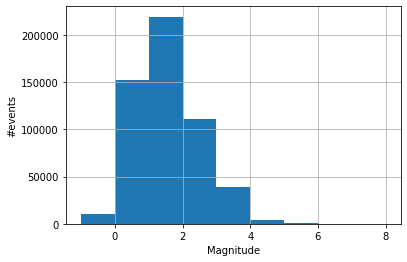

In [36]:
plt.hist(df['MAG'], np.arange(mn, mx + 1, 1))
plt.grid(True)
plt.xlabel('Magnitude')
plt.ylabel('#events')
plt.show()

И также точное количество

In [37]:
for i in range(mn, mx + 1):
    m = df[df['MAG'].astype('int') == i].count()[0]
    print(str(i) + '-' + str(i + 1) + ': ' + str(m))

-1-0: 17
0-1: 162403
1-2: 219304
2-3: 111430
3-4: 38474
4-5: 3700
5-6: 448
6-7: 68
7-8: 9
8-9: 1


Выведем средние, максимальные и минимальные значения даты/долготы/широты/магнитуды


In [38]:
statistics = df[['DATE', 'LAT', 'LON', 'MAG']].min().to_frame(name='min')
statistics['max'] = df[['DATE', 'LAT', 'LON', 'MAG']].max()

In [39]:
a = df[['LAT', 'LON', 'MAG']].mean()

Для подсчета средней даты переведем в юлианскую дату (эти функции я не от нечего делать писала - это я честно скопировала с чужого github'а)

In [40]:
def date_to_jd(year,month,day):
    if month == 1 or month == 2:
        yearp = year - 1
        monthp = month + 12
    else:
        yearp = year
        monthp = month
    if ((year < 1582) or
        (year == 1582 and month < 10) or
        (year == 1582 and month == 10 and day < 15)):
        B = 0
    else:
        A = math.trunc(yearp / 100.)
        B = 2 - A + math.trunc(A / 4.)
    if yearp < 0:
        C = math.trunc((365.25 * yearp) - 0.75)
    else:
        C = math.trunc(365.25 * yearp)
    D = math.trunc(30.6001 * (monthp + 1))
    jd = B + C + D + day + 1720994.5
    return jd

In [41]:
def jd_to_date(jd):
    jd = jd + 0.5
    F, I = math.modf(jd)
    I = int(I)
    A = math.trunc((I - 1867216.25)/36524.25)
    if I > 2299160:
        B = I + 1 + A - math.trunc(A / 4.)
    else:
        B = I   
    C = B + 1524
    D = math.trunc((C - 122.1) / 365.25)
    E = math.trunc(365.25 * D)
    G = math.trunc((C - E) / 30.6001)
    day = C - E + F - math.trunc(30.6001 * G)
    if G < 13.5:
        month = G - 1
    else:
        month = G - 13
        
    if month > 2.5:
        year = D - 4716
    else:
        year = D - 4715
        
    return date(int(year), int(month), int(day))

In [42]:
df['JD'] = df.apply(lambda x: date_to_jd(x['DATE'].year, x['DATE'].month, x['DATE'].day), axis=1)

In [43]:
mean_JD = df['JD'].mean()

In [44]:
a['DATE'] = jd_to_date(mean_JD)

In [45]:
statistics['mean'] = a

In [46]:
statistics

,min,max,mean
DATE,1995-01-01,2004-12-31,2001-12-31
LAT,27.5,42.5,35.385917
LON,130.0,144.0,136.821821
MAG,-1.3,8.0,1.499851


### 3 Подсчет средней магнитуды и плотности землетрясений 

Посчитаем расстояние $dx$ и $dy$ - расстояния по долготе и по широте соответсвующие $R$

In [110]:
df = pd.read_csv('raw_data.csv')

In [112]:
df['DATE'] = df.apply(lambda x: date(int(x['DATE'][:4]), int(x['DATE'][5:7]), int(x['DATE'][8:10])), axis=1)
df['COORDINATE'] = df.apply(lambda x: (x['LAT'], x['LON']), axis = 1)

In [113]:
yen = float(yen)
yst = float(yst)
xen = float(xen)
xst = float(xst)

In [114]:
R_earth = 6371
y_mean = (yst + yen) / 2

Плотность будет иметь размерность $\frac{1}{\text{км}^2 \cdot \text{дни}}$

In [123]:
x = df.iloc[50]

In [137]:
def density(x, df, R = 100, T = 365):
    dy = (R * 360) / (2 * np.pi * R_earth)
    dx = (R * 360) / (2 * np.pi * R_earth * np.cos(np.deg2rad(y_mean)))
    
    suit = [False] * df.shape[0]
    
    start_date = x['DATE']
    i = df[df['EVENTID'] == x['EVENTID']].index[0]
    while i >= 0 and (x['DATE'] - df.iloc[i]['DATE']) < timedelta(days = T):
        if abs(df.iloc[i]['LON'] - x['LON']) <= dx and abs(df.iloc[i]['LAT'] - x['LAT'] <= dy):
            if geodesic(x['COORDINATE'], df.iloc[i]['COORDINATE']).km < R and (x['DATE'] - df.iloc[i]['DATE']) < timedelta(days = T):
                suit[i] = True
        i -= 1
    
    n = suit.count(True)
    density = n / (np.pi * R ** 2 * T)
    return density

In [50]:
def mean_mag(x, df, R = 200, T = 700):
    dy = (R * 360) / (2 * np.pi * R_earth)
    dx = (R * 360) / (2 * np.pi * R_earth * np.cos(np.deg2rad(y_mean)))
    suit = [False] * df.shape[0]
    for i in range(0, df.shape[0]):
        if abs(df.iloc[i]['LON'] - x['LON']) <= dx and abs(df.iloc[i]['LAT'] - x['LAT'] <= dy):
            if distance(x['COORDINATE'][, df.iloc[i]['COORDINATE']).km < R and (x['DATE'] - df.iloc[i]['DATE']) < timedelta(days = T):
                suit[i] = True
    res = suit * df['MAG']
    a = res.to_list()
    m = res.sum() / (len(a) - a.count(0))
    return m

Возьмем первую тысячу объектов, чтобы понять как долго будет считаться новый столбец

In [133]:
df_test = df[:1000].copy()

In [138]:
%%time

df_test['DENSITY'] = df_test.apply(lambda x: density(x, df_test), axis = 1)

CPU times: user 2min 46s, sys: 6.66 ms, total: 2min 46s
Wall time: 2min 46s


Вся таблица таким темпом должна посчитаться за 22 часа

In [118]:
%%time
df_test['MEAN MAG'] = df.apply(lambda x: mean_mag(x, df), axis = 1)

CPU times: user 2h 37min 39s, sys: 911 ms, total: 2h 37min 40s
Wall time: 2h 37min 41s


Считалось долго, поэтому сохраним эту таблицу на всякий пожарный

In [119]:
df.to_csv('data_edit_1.csv', index=False)

### 4. Конвертер

Будем записывать в первой строке границы прямоугольника: $x_{st}$, $x_{en}$, $y_{st}$, $y_{en}$.

Также начало временного промежутка $T_{st}$

In [14]:
import os

In [44]:
df = pd.read_csv('data_edit_1.csv')

In [45]:
df.head()

,EVENTID,TYPE,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR MAG,TYPE MAG,MAG,COORDINATE,JD,DENSITY,MEAN MAG
0,1004915,ke,ISC,1997-01-04,12:31:52.00,33.8238,131.1687,13.7,,NIED,Mw,3.8,"(33.8238, 131.1687)",2450452.5,0.000003,3.881407
1,1005850,ke,ISC,1997-01-11,05:50:23.79,31.5974,131.7461,40.0,,NIED,Mw,5.4,"(31.5974, 131.7461)",2450459.5,0.000013,4.118780
2,1006351,ke,ISC,1997-01-14,08:48:35.66,33.2363,132.3621,7.9,,NIED,Mw,3.5,"(33.2363, 132.3621)",2450462.5,0.000010,3.925784
3,1006386,ke,ISC,1997-01-14,14:46:53.62,30.5042,131.5143,34.4,,NIED,Mw,4.5,"(30.5042, 131.5143)",2450462.5,0.000013,4.242417
4,1006639,ke,ISC,1997-01-16,06:10:37.40,31.7345,131.7291,33.8,,NIED,Mw,3.9,"(31.7345, 131.7291)",2450464.5,0.000013,4.103390


In [11]:
df['DATE'] = df.apply(lambda x: date(int(x['DATE'][:4]), int(x['DATE'][5:7]), int(x['DATE'][8:10])), axis=1) 

In [33]:
if os.path.exists("density") == False:
    os.mkdir("density")

In [34]:
initial_path = os.getcwd()
density_path = initial_path + '/density'

In [35]:
os.chdir("density")

In [36]:
f = open('density.txt', 'w')

In [37]:
if os.path.exists("data") == False:
    os.mkdir("data")

In [38]:
os.getcwd()

'/home/alina/Рабочий стол/iitp intern/density'

In [39]:
%%time

t = start_time
i = 1
T = 365
first_line = str(xst) + ' ' + str(xen) + ' ' + str(yst) + ' ' + str(yen)

while t < end_time:
    file_name = 'density' + str(i) + '.txt'
    f.write(file_name + '\n')
    
    os.chdir("data")
    f_t = open(file_name, 'w')
    f_t.write(first_line + ' ' + str(t) + '\n')
    
    t = t + timedelta(days = T)
    df_t = df[(df['DATE'] < t) & (df['DATE'] >= (t - timedelta(days = T)))]
    x = xst
    while x < xen:
        f_t.write(str(x) + ' ')
        df_t_x = df_t[(df_t['LON'] < (x + 1)) & (df_t['LON'] >= x)].sort_values(by='LAT')
        if df_t_x.empty:
            a = ' '
        else:
            a = df_t_x['DENSITY'].to_string(index=False).replace('\n', ' ')
        f_t.write(a + '\n')
        x += 1
    f_t.close()
    os.chdir(density_path)
    i += 1

CPU times: user 236 ms, sys: 7.92 ms, total: 244 ms
Wall time: 244 ms


In [40]:
os.chdir(initial_path)
f.close()

Теперь то же самое со средней магнитудой

In [41]:
if os.path.exists("mean magnitude") == False:
    os.mkdir("mean magnitude")

In [42]:
initial_path = os.getcwd()
density_path = initial_path + '/mean magnitude'

In [43]:
os.chdir("mean magnitude")

In [44]:
f = open('mean magnitude.txt', 'w')

In [45]:
if os.path.exists("data") == False:
    os.mkdir("data")

In [46]:
%%time

t = start_time
i = 1
T = 700
first_line = str(xst) + ' ' + str(xen) + ' ' + str(yst) + ' ' + str(yen)

while t < end_time:
    file_name = 'mean magnitude' + str(i) + '.txt'
    f.write(file_name + '\n')
    
    os.chdir("data")
    f_t = open(file_name, 'w')
    f_t.write(first_line + ' ' + str(t) + '\n')
    
    t = t + timedelta(days = T)
    df_t = df[(df['DATE'] < t) & (df['DATE'] >= (t - timedelta(days = T)))]
    x = xst
    while x < xen:
        f_t.write(str(x) + ' ')
        df_t_x = df_t[(df_t['LON'] < (x + 1)) & (df_t['LON'] >= x)].sort_values(by='LAT')
        if df_t_x.empty:
            a = ' '
        else:
            a = df_t_x['MEAN MAG'].to_string(index=False).replace('\n', ' ')
        f_t.write(a + '\n')
        x += 1
    f_t.close()
    os.chdir(density_path)
    i += 1

CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 182 ms
